<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 뉴스기사 요약해보기

# 1 개요

## 1-1. 목표

*  뉴스에 대해서 추상적 요약과 추출적 요약을 한다.

## 1-2. 사전준비

### ■ 기본 라이브러리 설치 및 load하기

In [119]:
!pip install summa
import tqdm as tqdm
from tqdm import tqdm
import os, re
import nltk
import tensorflow
import summa
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention
from summa.summarizer import summarize
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### ■ 기본 함수 정의하기

In [120]:
 # 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

# 제한된 샘플에 대한 비율 확인 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence  

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp   

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp     

# 2 데이터 수집하기

## 2-1. 데이터 download하기

In [105]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

## 2-2. 데이터 확인하기

In [106]:
data.shape

(98401, 2)

In [107]:
data.sample(10)

,headlines,text
64073,Fireworks factory explosion kills 23 in Indonesia,At least 23 people were killed and 43 others w...
6705,"Doesn't take a genius to get that Alia, Ranbir...","Filmmaker Mahesh Bhatt, while talking about hi..."
42378,Pilots suspended for shooting Snapchat videos ...,British airline easyJet has suspended two pilo...
69509,Rajdeep Sardesai calls Arnab's Gujarat riot st...,TV Today Consulting Editor Rajdeep Sardesai on...
48945,Petition to live-stream SC proceedings gets 43...,An online petition by lawyer Indira Jaising se...
96248,Teaser of Pratyusha Banerjee's last short film...,The teaser of late TV actress Pratyusha Banerj...
18488,"NASA's Kepler telescope wakes up, starts plane...",NASA's planet-hunting Kepler space telescope h...
50482,"Constable wrestles gun out of trader's hands, ...",A constable in Hyderabad was rewarded Ã¢ÂÂ¹10...
21847,ITBP to give soldiers half-day off on their bi...,Indo-Tibetan Border Police has decided to gran...
9480,Who are the 18 members on Reserve Bank of Indi...,The RBI's 18-member board includes Governor Ur...


In [108]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [109]:
data.loc[0]

headlines    upGrad learner switches to career in ML & Al w...
text         Saurav Kant, an alumnus of upGrad and IIIT-B's...
Name: 0, dtype: object

In [110]:
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [111]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

# 3 추상적 요약

## 3-1. 데이터 전처리

### ■ 중복 제거하기

In [112]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [113]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### ■ Null값 체크하기

In [114]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [115]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98262


### ■ 텍스트 정규화하기

In [116]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [117]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [170]:
# text 전처리
clean_text = []
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

100%|██████████| 97528/97528 [07:58<00:00, 203.84it/s]


In [171]:
# text 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years', 'speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve ju

In [172]:
# headlines 전처리 (불용어는 제거 하지않음)
clean_summary = []
for s in tqdm(data['headlines']):
    clean_summary.append(preprocess_sentence(s, False))

100%|██████████| 97528/97528 [00:23<00:00, 4170.96it/s]


In [173]:
# headlines 전처리 후 출력
print("Headlines 전처리 후 결과: ", clean_summary[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam', 'rahat fateh ali khan denies getting notice for smuggling currency']


In [174]:
# 다시 empty 샘플 찾아 없애기
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [175]:
# 이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 점검하기
data.isnull().sum()

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64

### ■ 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 44
텍스트의 평균 길이 : 35.02887375933065
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 9.289506603231892


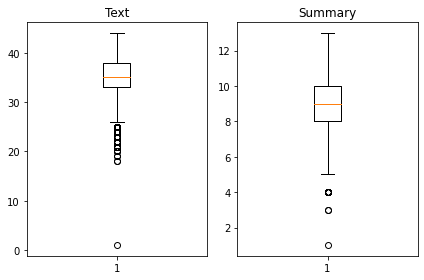

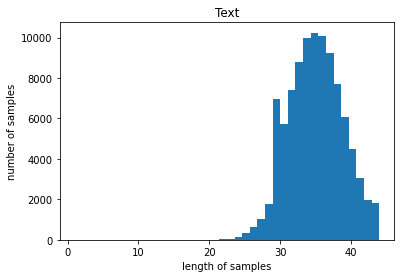

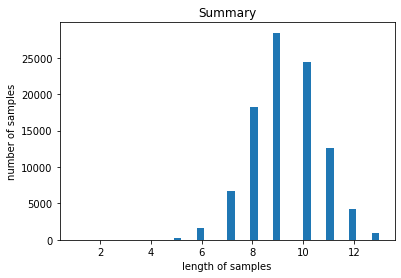

In [215]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [224]:
# 상기 그래프를 토대로 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하기
text_max_len = 37
summary_max_len = 11

In [225]:
# 비율 확인하기
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.74258674431958
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9467742596997786


In [226]:
# 정해진 길이보다 길면 제외하기
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 68388


In [227]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...


In [228]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장하기
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [229]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[28942 15165 18662 ... 50468 44530 36314]


In [230]:
# 상기 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 섞인 샘플 만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [231]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13677


In [232]:
# 상기 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분하기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 54711
훈련 레이블의 개수 : 54711
테스트 데이터의 개수 : 13677
테스트 레이블의 개수 : 13677


### ■ 정수 인코딩

In [233]:
# Keras의 토크나이저 이용
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [234]:
# 등장 빈도수가 30회 미만인 단어들이 이 데이터에서 비중 확인
threshold = 30
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56915
등장 빈도가 29번 이하인 희귀 단어의 수: 49293
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7622
단어 집합에서 희귀 단어의 비율: 86.6080997979443
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.257250449609574


In [235]:
# 희귀 단어를 제외한 단어 집합의 크기를 어림잡아 7,000으로 제한해보기
src_vocab = 7000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 18,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [236]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
# 변환 전, 샘플 출력
print("before: \n", encoder_input_train[:3])

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

before: 
 ['uber ola drivers go strike across cities including mumbai gurugram nation capital delhi march drivers plan protest front ola uber offices demanding companies ensure business worth lakh per month also seek fares decided according vehicles'
 'graham prior coach south africa squash team died collapsing road due heart attack team world junior squash championship play match singapore chennai year old way along players board team bus heading back hotel collapsed'
 'delhi high court monday stayed cutting trees redevelopment seven colonies south delhi till next date hearing july court asked state owned company overseeing project capital afford cut trees stay comes amid widespread protests delhi residents']


In [237]:
# 변환 후, 잘 진행되었는지 샘플 출력
print("after: \n", encoder_input_train[:3])

after: 
 [[552, 2404, 1591, 269, 963, 263, 1515, 106, 74, 1127, 548, 348, 25, 312, 1591, 749, 601, 804, 2404, 552, 2372, 1075, 376, 699, 372, 214, 45, 117, 124, 7, 2346, 5319, 416, 42, 665], [3018, 617, 197, 697, 47, 198, 484, 105, 929, 185, 47, 23, 2951, 2052, 277, 104, 1468, 969, 3, 13, 246, 301, 498, 155, 47, 635, 5320, 173, 595, 1620], [25, 92, 16, 55, 2850, 3138, 2373, 302, 197, 25, 549, 176, 742, 736, 406, 16, 61, 19, 866, 35, 449, 348, 4738, 652, 2373, 975, 68, 475, 5256, 808, 25, 1163]]


In [238]:
# headlines 데이터에 대해서도 동일한 작업을 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [247]:
# headlines 데이터의 등장 빈도수가 40회 미만인 단어들이 이 데이터의 비중 확인
threshold = 40
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25961
등장 빈도가 39번 이하인 희귀 단어의 수: 23885
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2076
단어 집합에서 희귀 단어의 비율: 92.00338969993452
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 23.28993873491388


In [248]:
# text데이터에서처럼, headlines데이터에서도 이 희귀단어들을 2,000으로 크기 제한
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1214, 229, 3, 331, 7, 484, 7, 681], [1, 1312, 375, 158, 9, 7, 500, 4, 1289], [1, 310, 122, 6, 1698, 4, 25, 692], [1, 130, 80, 111, 311, 47, 720, 14], [1, 126, 76, 7, 327, 827, 1398, 7, 255, 1102]]
target
decoder  [[1214, 229, 3, 331, 7, 484, 7, 681, 2], [1312, 375, 158, 9, 7, 500, 4, 1289, 2], [310, 122, 6, 1698, 4, 25, 692, 2], [130, 80, 111, 311, 47, 720, 14, 2], [126, 76, 7, 327, 827, 1398, 7, 255, 1102, 2]]


### ■ 패딩하기

In [249]:
# 패딩 하기전, 빈(empty)샘플 점검
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))


삭제할 훈련 데이터의 개수 : 9
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 54702
훈련 레이블의 개수 : 54702
테스트 데이터의 개수 : 13676
테스트 레이블의 개수 : 13676


In [250]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 3-2. 기본 seq2seq 모델 설계

### ■ 인코더 설계하기 (함수형API 이용)

In [251]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더의 입력
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### ■ 디코더 설계하기

In [252]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### ■ 디코더 출력층 설계하기

In [253]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 37, 128)      896000      ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 37, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 3-3. 어텐션 매커니즘 사용 모델만들기 (Tensorflow함수 이용)

In [254]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 37, 128)      896000      ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 37, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 3-4. 모델 학습하기 (EarlyStopping 이용)

In [255]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
214/214 [==============================] - 613s 3s/step - loss: 4.2539 - val_loss: 3.9506
Epoch 2/50
214/214 [==============================] - 585s 3s/step - loss: 3.8248 - val_loss: 3.6827
Epoch 3/50
214/214 [==============================] - 582s 3s/step - loss: 3.5648 - val_loss: 3.4674
Epoch 4/50
214/214 [==============================] - 595s 3s/step - loss: 3.3580 - val_loss: 3.3136
Epoch 5/50
214/214 [==============================] - 635s 3s/step - loss: 3.2012 - val_loss: 3.1970
Epoch 6/50
214/214 [==============================] - 585s 3s/step - loss: 3.0741 - val_loss: 3.1036
Epoch 7/50
214/214 [==============================] - 588s 3s/step - loss: 2.9646 - val_loss: 3.0275
Epoch 8/50
214/214 [==============================] - 588s 3s/step - loss: 2.8697 - val_loss: 2.9690
Epoch 9/50
214/214 [==============================] - 583s 3s/step - loss: 2.7856 - val_loss: 2.9235
Epoch 10/50
214/214 [==============================] - 582s 3s/step - loss: 2.7113 - val_lo

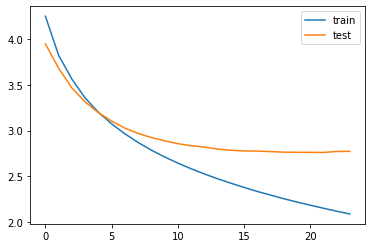

In [256]:
# 훈련 데이터의 손실과 검증 데이터의 손실의 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 3-5. 인퍼런스 모델 구현하기 (훈련용이 아닌 실제 동작용)

In [257]:
# 테스트 단계에서 정수 인덱스 행렬의 텍스트 데이터를 실제 데이터 복원위해, 3개의 사전 준비
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [258]:
# 인퍼런스 모델 기본구조
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [259]:
# 어텐션메커니즘을 사용하는 출력층을 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 37, 128)      896000      ['input_5[0][0]']                
                                                                                                  
 lstm_8 (LSTM)                  [(None, 37, 256),    394240      ['embedding_4[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 3-6. 모델 테스트하기

### ■ 시험방법: index기준으로 10번째, 24번째 뉴스에 대해 테스트 실시

In [260]:
# index기준으로 10번째, 24번째 뉴스에 대한 테스트
for i in (10, 24):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : different caused condition called lets people experience hearing colours music believed caused connections leads break phenomenon name greek word means together 
실제 요약 : lets people music 
예측 요약 :  how did not have


원문 : tech billionaires combined net worth trillion according forbes world billionaires list three world five richest people earned technology firms world tech billionaires got past year notably richest person tech fortune microsoft co founder bill gates 
실제 요약 : tech own of the world wealth 
예측 요약 :  world richest firm loses bn in wealth in




# 4 추출적 요약 (Summa 이용)

### ■ 샘플1개 대상 시험

In [353]:
text1 = "Prime Minister Narendra Modi on Wednesday said the people with 'negative mindset' are questioning him and his government for floating pro-poor schemes. He added negative mindset people are raising doubts about schemes such as building toilets and providing free gas connections to the poor. He further said that negative mentality laced with a vested interest still exists in the country."
headline1 = "PM Modi stops speech after cameraman faints, asks officers to help"
print("원문 :", text1)
print("실제 요약 :", headline1)
print("예측 요약 :", summarize(text1, words=11))
print("\n")

원문 : Prime Minister Narendra Modi on Wednesday said the people with 'negative mindset' are questioning him and his government for floating pro-poor schemes. He added negative mindset people are raising doubts about schemes such as building toilets and providing free gas connections to the poor. He further said that negative mentality laced with a vested interest still exists in the country.
실제 요약 : PM Modi stops speech after cameraman faints, asks officers to help
예측 요약 : Prime Minister Narendra Modi on Wednesday said the people with 'negative mindset' are questioning him and his government for floating pro-poor schemes.




# 5 두 요약 결과 비교

## 5-1. 평가 항목

### ■ 평가항목 <br>
  1) 문법완성도 측면 <br>
  2) 핵심단어 포함 측면
### ■ 등급: 상, 중, 하

## 5-2. 평가

#### ► 추상적 요약
- 문법적으로 잘 맞지 않는 경우가 많다.
- 의미요약이 잘 되지않을 뿐만 아니라, 핵심단어 선정도 잘 되지 않았다.

##### ► 추출적 요약
- 문법적으로는 문제가 없었다.
- 의미전달이 잘 되지 않으나, 가끔 핵심단어가 포함되기도 한다.
- 추가로, 구현상 문제로써, words가 짧을 수록 요약이 거의 안되는 문제가 있다.

### ■ 비교 평가

|평가 항목|문법완성도 측면|핵심단어포함 측면|
|---|---|---|
|추상적 요약|등급: 중|등급: 하|
|추출적 요약|등급: 상|등급: 중|